## Analyse der im Datenset enthaltenen Personen

Im folgenden sollen die verschiedenen im erstellten Datenset Dump.xml erwähnten Personen aus diesem extrahiert und analysiert werden:

### Importieren der benötigten Bibliotheken

In [68]:
import pandas as pd
from lxml import etree
import unicodedata
import plotly.express as px
import numpy as np

Die einzelnen Einträge unter additional_author und added_rela sind jeweils durch ein Semikolon getrennt - da es im Eintrag zu Franz Siegfried Müller allerdings zwei Einträge der Relation (zwei subfields $e) für beide Funktionen als Verfasser sowie als Herausgeber gab, sind die Einträge hier nicht mehr eindeutig zuordnenbar (2 Einträge zu additional_authors vs. 3 added_rela-Einträge). 

Für eine genauere Analyse der einzelnen Personen inklusive der Beziehungen zum Werk ist es also nötig, die Funktion anzupassen und die einzelnen Unterfelder in Abhängigkeit ihrer "datafields" zu extrahieren und die Abhängigkeiten entsprechend abzubilden. Dazu wird die Funktion von eben etwas verändert und erweitert: 

In [69]:
# Erweiterte Funktion zum Extrahieren der Inhalte: 
def parse_record_advanced(record):
    ns = {"marc": "http://www.loc.gov/MARC21/slim"}

    def extract_text(xpath_query):
        element = xpath_query.split("/")
        parentpath = xpath_query.split("/")[0]
        if len(element) == 1:
            fields = record.xpath(xpath_query, namespaces=ns)
            if fields:
                return "; ".join(field.text.replace('\x98', '').replace('\x9c', '') for field in fields if field.text)
            return "unknown"
        else:
            childpath = xpath_query.split("/")[1]
            parentfields = record.xpath(parentpath, namespaces=ns)
            result = []
            
            for parent in parentfields:
                subfields = parent.xpath(childpath, namespaces=ns)
                if subfields:
                    text = " / ".join(field.text.replace('\x98', '').replace('\x9c', '') for field in subfields if field.text)
                else:
                    text = ""
                result.append(text)
    
            if len(result) == 0:
                return None
            elif len(result) == 1:
                return result[0]
            else:
                return result
                

    # Extract fields
    idn = extract_text("marc:controlfield[@tag='001']")
    titel = extract_text("marc:datafield[@tag='245']/marc:subfield[@code='a']")
    author = extract_text("marc:datafield[@tag='100']/marc:subfield[@code='a']")
    author_rela = extract_text("marc:datafield[@tag='100']/marc:subfield[@code='e']")
    add_author = extract_text("marc:datafield[@tag='700']/marc:subfield[@code='a']")
    add_author_rela = extract_text("marc:datafield[@tag='700']/marc:subfield[@code='e']")
    
    return {
        "idn": idn,
        "titel": titel,
        "author": author,
        "author_rela": author_rela,
        "additional_author": add_author,
        "added_rela": add_author_rela,
               
    }


### Anwenden der Funktion auf das Datenset Dump.xml: 

In [70]:
# Laden der MARC-xml-Datei in ElementTree und umwandeln in eine Liste an Datensätzen: 
tree2 = etree.parse('Dump.xml')
root2 = tree2.getroot()
ns = {'marc': 'http://www.loc.gov/MARC21/slim'}
records2 = root2.findall('.//marc:record', namespaces=ns)
print("Gefundene Records:", len(records2))

Gefundene Records: 1194


In [71]:
# Ausgabe in einem Dataframe
result_complete = [parse_record_advanced(record) for record in records2]
df_new = pd.DataFrame(result_complete)
df_new

,idn,titel,author,author_rela,additional_author,added_rela
0,1259638626,"Literature, Theory and Big Data",None,None,"[Gallego Cuiñas, Ana, González Blanco, Azucena]","[Herausgeber, Herausgeber]"
1,1324697490,Der Stachel des Digitalen,"Krämer, Sybille",Verfasser,None,None
2,1173821252,Digital Humanities,None,None,"Jannidis, Fotis",
3,1327011255,A Scalable View on the Visual Narrative,"Ruth, Nicolas",Verfasser,"[Burghardt, Manuel, Liebl, Bernhard]","[Verfasser, Verfasser]"
4,1333471610,Aigyptos – Eine Datenbank zur Literaturrecherc...,"Ullmann, Martina",Verfasser,None,None
...,...,...,...,...,...,...
1189,1211392031,Satzung zur Änderung der Besonderen Bestimmun...,None,None,None,None
1190,1316214443,Special issue on digital humanities and East A...,"Horváth, Alíz",Verfasser,"De Weerdt, Hilde",Verfasser
1191,1240389205,TEACHING DIGITAL CULTURAL HERITAGE AND DIGITAL...,"Münster, S.",Verfasser,"[Fritsche, K., Richards-Rissetto, H., Apolloni...","[Verfasser, Verfasser, Verfasser, Verfasser, V..."
1192,1160749264,Towards a manifesto for a critical digital hum...,"Grimshaw, Mike",Verfasser,None,None


### Unwandeln des Dataframes für die weitere Analyse

Das aktuelle Dataframe verfügt nun über jeweils 2 Spalten, in denen Personen gelistet werden, sowie zwei zugehörige Spalten, die deren Relation zum Werk beschreiben. Um im weiteren Verlauf alle Personen gleichermaßen listen und analyiseren zu können, muss das Dataframe nun noch etwas angepasst werden. 

Ziel ist es, nur noch eine Spalte "person" mit einer zugehörigen Spalte "person_rela" zu erzeugen und die Daten aus author, author_rela, additional_author und added_rela entsprechend in diese Spalten zu überführen. Außerdem soll die Beziehung der jeweiligen Person zum Werk erhalten bleiben. Das neue Dataframe sollte also in etwas folgendermaßen aussehen: 

Um dies zu erreichen sind mehrere Schritte nötig: Zunächst werden die Listen, die sich in `additional_author` und `added_rela` befinden mit Hilfe der .explode()-Funktion von Pandas "entpackt". Dies bewirkt, dass eine Spalte, die Listen oder ähnliche Strukturen enthält so dupliziert wird, dass jede Listeneinheit in eine eigene Zeile aufgeteilt wird, während die anderen Spalten unverändert bleiben. Gleichzeitig werden die Spalten `author` und `author_rela` für die gewünschte neue Struktur umbenannt:



In [72]:
df_explode = df_new.explode(['additional_author', 'added_rela'])
df_persons = df_explode.rename(columns={'author': 'person', 'author_rela': 'person_rela'}).copy()
df_persons

,idn,titel,person,person_rela,additional_author,added_rela
0,1259638626,"Literature, Theory and Big Data",None,None,"Gallego Cuiñas, Ana",Herausgeber
0,1259638626,"Literature, Theory and Big Data",None,None,"González Blanco, Azucena",Herausgeber
1,1324697490,Der Stachel des Digitalen,"Krämer, Sybille",Verfasser,None,None
2,1173821252,Digital Humanities,None,None,"Jannidis, Fotis",
3,1327011255,A Scalable View on the Visual Narrative,"Ruth, Nicolas",Verfasser,"Burghardt, Manuel",Verfasser
...,...,...,...,...,...,...
1191,1240389205,TEACHING DIGITAL CULTURAL HERITAGE AND DIGITAL...,"Münster, S.",Verfasser,"Schwartze, V.",Verfasser
1191,1240389205,TEACHING DIGITAL CULTURAL HERITAGE AND DIGITAL...,"Münster, S.",Verfasser,"Smolarski, R.",Verfasser
1192,1160749264,Towards a manifesto for a critical digital hum...,"Grimshaw, Mike",Verfasser,None,None
1193,1154693864,Web-based Multimedia Mapping for Spatial Analy...,"Hu, Shunfu",Verfasser,"Karna, Brajesh",Sonstige


Nun wird ein neues Dataframe erstellt, welches folgendermaßen befüllt wird: 

- Kopieren jeder Zeile in das neue Dataframe 
- Prüfung, ob ein Eintrag unter `additional_author` vorhanden ist. Wenn ja: 
    - Erneutes Kopieren der Zeile
    - Überschreiben der Einträge in `person` und `person_rela` mit den Werten aus `additional_author` und `added_rela` in der neuen Zeile

In [73]:
# Erstellen des neuen Dataframes: 
new_rows = []

for index, row in df_persons.iterrows():
    new_rows.append(row) # Kopieren der Zeilen

    if pd.notna(row['additional_author']):
        new_row = row.copy() 
        new_row['person'] = row['additional_author'] 
        new_row['person_rela'] = row['added_rela']  
        new_rows.append(new_row)  

new_df = pd.DataFrame(new_rows)
new_df.head()


,idn,titel,person,person_rela,additional_author,added_rela
0,1259638626,"Literature, Theory and Big Data",None,None,"Gallego Cuiñas, Ana",Herausgeber
0,1259638626,"Literature, Theory and Big Data","Gallego Cuiñas, Ana",Herausgeber,"Gallego Cuiñas, Ana",Herausgeber
0,1259638626,"Literature, Theory and Big Data",None,None,"González Blanco, Azucena",Herausgeber
0,1259638626,"Literature, Theory and Big Data","González Blanco, Azucena",Herausgeber,"González Blanco, Azucena",Herausgeber
1,1324697490,Der Stachel des Digitalen,"Krämer, Sybille",Verfasser,None,None


Entfernen der Spalten "additional_author" und "added_rela" mit anschließender Löschung doppelter Zeilen sowie von Zeilen, die keinen Eintrag unter "person" haben (da sie ursprünglich bspw. nicht über einen 100er Eintrag, sondern nur über einen 700er Eintrag verfügten): 

In [74]:
new_df = new_df.drop(columns=['additional_author', 'added_rela'])
new_df.drop_duplicates(inplace=True)
new_df.dropna(subset=['person'], inplace=True)
new_df

,idn,titel,person,person_rela
0,1259638626,"Literature, Theory and Big Data","Gallego Cuiñas, Ana",Herausgeber
0,1259638626,"Literature, Theory and Big Data","González Blanco, Azucena",Herausgeber
1,1324697490,Der Stachel des Digitalen,"Krämer, Sybille",Verfasser
2,1173821252,Digital Humanities,"Jannidis, Fotis",
3,1327011255,A Scalable View on the Visual Narrative,"Ruth, Nicolas",Verfasser
...,...,...,...,...
1191,1240389205,TEACHING DIGITAL CULTURAL HERITAGE AND DIGITAL...,"Smolarski, R.",Verfasser
1192,1160749264,Towards a manifesto for a critical digital hum...,"Grimshaw, Mike",Verfasser
1193,1154693864,Web-based Multimedia Mapping for Spatial Analy...,"Hu, Shunfu",Verfasser
1193,1154693864,Web-based Multimedia Mapping for Spatial Analy...,"Karna, Brajesh",Sonstige


In [66]:
# Optional: Speichern des Dataframes als CSV
new_df.to_csv("personen.csv", encoding="utf-8")

### Analyse:

Gruppieren und Zählen der einzelnen Personen: 

In [76]:
# Häufigkeit der Autoren zählen und Anzeige 50 häufigsten Autoren
person_counts = new_df['person'].value_counts().head(50).reset_index()
person_counts.columns=['person', 'count']
person_counts

,person,count
0,"Witt, Andreas",33
1,"Burghardt, Manuel",24
2,"Jannidis, Fotis",18
3,"Rapp, Andrea",12
4,"Moretti, Franco",12
5,"Klinke, Harald",11
6,"Ressel, Andrea",9
7,"Hinrichs, Erhard",9
8,"Wuttke, Ulrike",9
9,"Bender, Michael",9


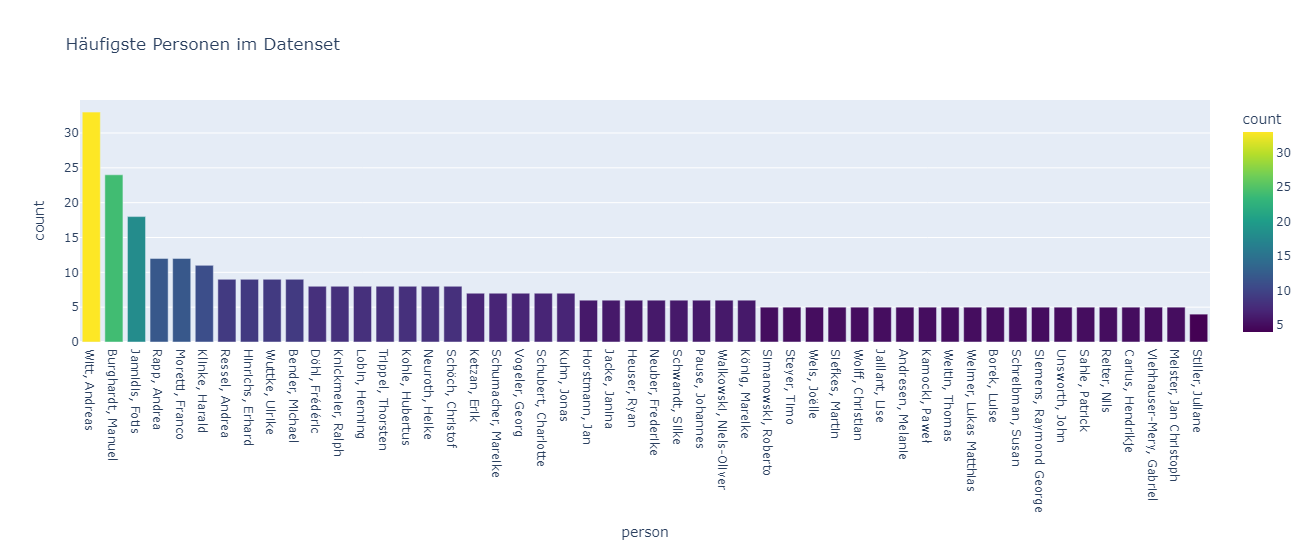

In [77]:
# Balkendiagramm erstellen
fig1 = px.bar(person_counts, x='person', y='count', height=550,
             title='Häufigste Personen im Datenset', color='count', color_continuous_scale='Viridis')
fig1.show()

Suche im Dataframe nach einer bestimmten Person: 

In [78]:
new_df.loc[new_df['person'] == 'Meyer, Thomas']

,idn,titel,person,person_rela
670,1185668071,Clio-Guide. Ein Handbuch zu digitalen Ressourc...,"Meyer, Thomas",Verfasser


Häufigkeiten der verschiedenen Rollen:

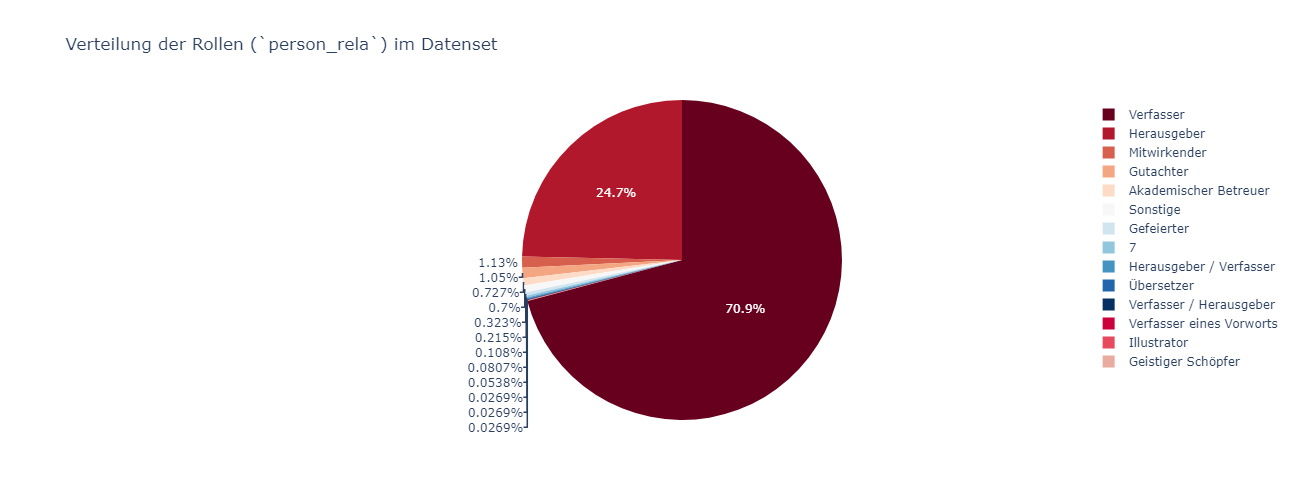

In [39]:
# Häufigkeit von "person_rela"
rela_counts = new_df['person_rela'].value_counts().head(25).reset_index()
rela_counts.columns=['person_rela', 'count']

# Kreisdiagramm erstellen
fig2 = px.pie(rela_counts, values='count', names='person_rela', title='Verteilung der Rollen (`person_rela`) im Datenset', 
              color_discrete_sequence=px.colors.sequential.RdBu, height=500)
fig2.show()